In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Upload the dataset

In [239]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

#Upload the Dataset
train = pd.read_csv('/content/train (1).csv')
test = pd.read_csv('/content/test (1).csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving test (1).csv to test (1).csv
Saving train (1).csv to train (1).csv


Firse we will need to deal with all of our catagorical datapoints and get rid of our empty data columns

In [240]:
from sklearn.preprocessing import LabelEncoder

non_numeric_columns = train.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

#Transform categorical data to numerical data
for column in non_numeric_columns:
  train[column] = le.fit_transform(train[column])
  test[column] = le.fit_transform(test[column])


train.head()
#test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000


In [241]:
len(train)

1460

Impute the missing columns

In [242]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

<Axes: >

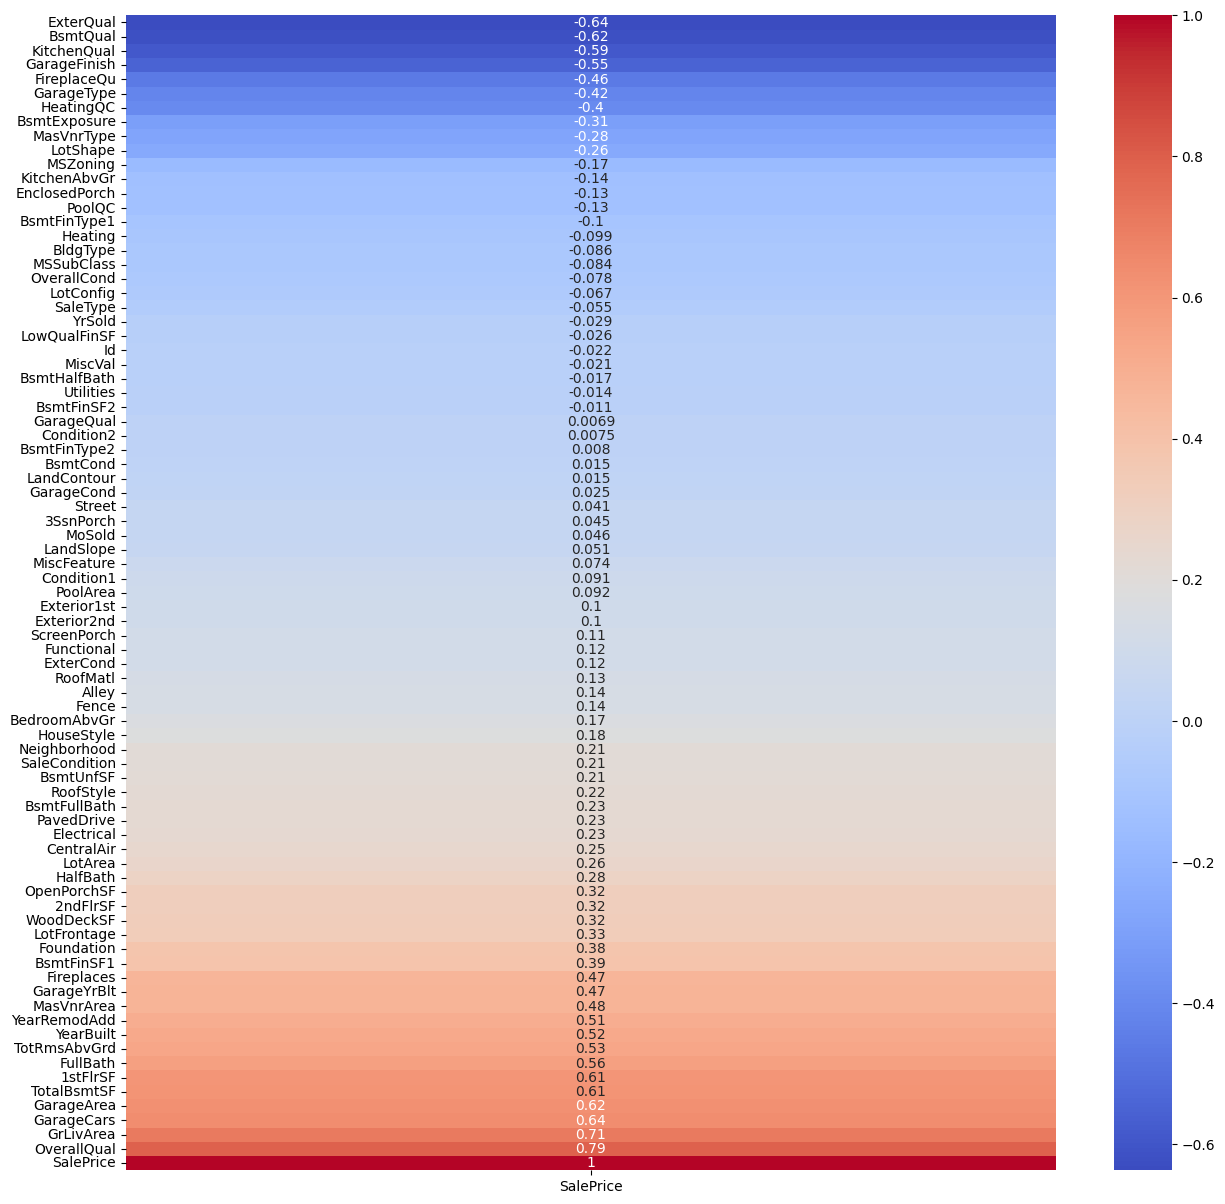

In [243]:
correlations = train.corr( )['SalePrice'].sort_values(ascending=True)
plt.figure(figsize=(15, 15))
sns.heatmap(correlations.to_frame(), cmap='coolwarm', annot=True)

Initialize our target and columns

In [244]:
X = train[train.columns.drop('SalePrice')]
y = train['SalePrice']

Begin Feature Selection

In [245]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

#Implement Recursive Feature Elimination to select optimal features
lr = LinearRegression()
rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(5), scoring='neg_mean_squared_error')
rfecv.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LinearRegression(), scoring='neg_mean_squared_error')

In [246]:
print('Optimal number of features: {}'.format(rfecv.n_features_))
X = train[X.columns[rfecv.support_]]

Optimal number of features: 69


In [247]:
X.columns
for column in X.columns:
  print('Feature: {}, Correlation: {} '.format(column,correlations[column]))

Feature: MSSubClass, Correlation: -0.08428413512659509 
Feature: MSZoning, Correlation: -0.16687220265320626 
Feature: LotFrontage, Correlation: 0.3349008515405512 
Feature: Street, Correlation: 0.041035535500049444 
Feature: Alley, Correlation: 0.1398677496916844 
Feature: LotShape, Correlation: -0.2555798704871225 
Feature: LandContour, Correlation: 0.015453241660960324 
Feature: Utilities, Correlation: -0.01431429614724878 
Feature: LotConfig, Correlation: -0.06739602315941755 
Feature: LandSlope, Correlation: 0.0511522481794664 
Feature: Neighborhood, Correlation: 0.21085146582230307 
Feature: Condition1, Correlation: 0.09115491154092803 
Feature: Condition2, Correlation: 0.0075127340363331 
Feature: BldgType, Correlation: -0.08559060818352954 
Feature: HouseStyle, Correlation: 0.18016262334399108 
Feature: OverallQual, Correlation: 0.7909816005838053 
Feature: OverallCond, Correlation: -0.07785589404867797 
Feature: YearBuilt, Correlation: 0.5228973328794967 
Feature: RoofStyle, C

After Recursive feature Elimination we will now be using 35 features in our model. We will now begin training our model.


Next we should try to reduce the dimensionality with principal component analysis

In [248]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Scale our data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_fit_X = scaler.fit_transform(test[X.columns])

#Apply PCA to reduce dimensionality
pca = PCA(n_components=6)
pca_X = pca.fit_transform(scaled_X)
pca_X_test = pca.fit_transform(scaled_fit_X)

#Ammount of Variance each component explains:
variance_Data = pca.explained_variance_ratio_
print('variance each PC explains: ', variance_Data)

variance each PC explains:  [0.14310255 0.05540241 0.04704805 0.03820865 0.03525524 0.03022035]


In [249]:
from sklearn.metrics import mean_squared_error
#Initialize our model
lr = LinearRegression()
#Train our model with the training data
lr.fit(pca_X,y)

#Form our predictions
y_pred = lr.predict(pca_X_test)

math.sqrt(mean_squared_error(y[0:1459], y_pred))

106189.29683734893

In [250]:
y_pred

array([116304.29989332, 164190.37824851, 186887.5213507 , ...,
       170068.33155213, 106825.40089665, 238146.53023806])

In [251]:
lr.coef_

array([22218.31500764,  5256.64480332,  5866.2259051 ,  -459.88717645,
        2417.32294778,  4652.90848927])

In [252]:
lr.score(pca_X_test,y_pred)

1.0

1.0 is considered the best score you can achieve in. Thus our model supposedly performs very well according to this

[]


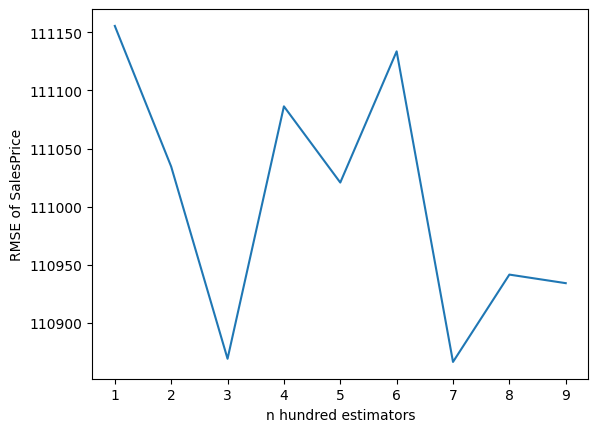

In [253]:
from sklearn.ensemble import RandomForestRegressor

tree_models = []
tree_scores = []
n = range(1,10)
for i in n:
  rf = RandomForestRegressor(n_estimators=100*i)
  rf.fit(pca_X, y)
  tree_models.append(rf)
  tree_scores.append(math.sqrt(mean_squared_error(y[0:1459], rf.predict(pca_X_test)[0:len(y)])))

plt.plot(n,tree_scores)
plt.ylabel('RMSE of SalesPrice')
plt.xlabel('n hundred estimators')
print(scores)

We see that random forest regressor did not perform better than linear regression in this instance.

106185.75572704767


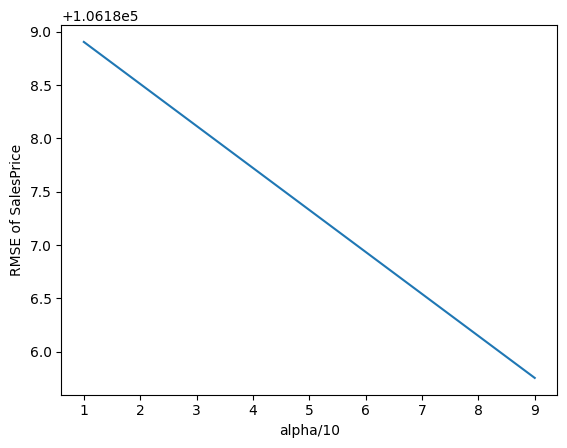

In [254]:
from sklearn.linear_model import Ridge

ridge_scores = []
ridge_models = []
ridge_predictions = []
a = range(1,10)
for i in a:
  ridge = Ridge(alpha=i/10)
  ridge_models.append(ridge)
  ridge.fit(pca_X, y)
  ridge_prediction = ridge.predict(pca_X_test)
  ridge_predictions.append(ridge_prediction)
  ridge_scores.append(math.sqrt(mean_squared_error(y[0:1459], ridge_prediction[0:len(y)])))

plt.plot(n,ridge_scores)
plt.ylabel('RMSE of SalesPrice')
plt.xlabel('alpha/10')

In [258]:
print(np.min(ridge_scores))

106185.75572704767


We see the Root Mean Squared error for Ridge Regression seemed to have improved our mean squared error

In [255]:
#Prepare our submission file.
submission  = test[['Id']]
submission['SalePrice'] = ridge_prediction[np.argmin(ridge_scores)]

<ipython-input-255-47f6b815a772>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['SalePrice'] = ridge_prediction[np.argmin(ridge_scores)]


In [260]:
submission['Id']  = submission['Id'].astype(int)

<ipython-input-260-7df607d071e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Id']  = submission['Id'].astype(int)


In [262]:
submission

,Id,SalePrice
0,1461,204362.885021
1,1462,204362.885021
2,1463,204362.885021
3,1464,204362.885021
4,1465,204362.885021
...,...,...
1454,2915,204362.885021
1455,2916,204362.885021
1456,2917,204362.885021
1457,2918,204362.885021


In [263]:
submission.to_csv('submission.csv', index=False)